# Support Vector Regression for Price Prediction

Use Technical Analysis indicators as input features.

Split train/test
Fit SVR to technical indicators.
Report mean squared error.

Prediction for single stock. In this notebook, BANPU is chosen arbitrary.
- Predict tomorrow's closing price.
- Use five technical indicators.
- Technical indicator choice and methodology came from Henrique2018.
- Model trained using data from 2014-2016. Model test on holdout data set of 2017, 2018-2020.
- Linear Kernel perform better than RBF. Confirms literature knowledge. RBF was getting 88 MSE on training.
- Linear Kernel performance degrades in holdout sets. MSE and MAE are increasing exponentially.


## Linear Kernel


| | In-sample (Training) | Out-of-sample (Holdout) | Out-of-sample (Holdout) |
| --- | --- | --- | --- |
| Year | 2014-2016 | 2017 | 2018-2020 |
| MSE | 0.220 | 0.272 | 0.165 |
| MAE | 0.338 | 0.402 | 0.310 |
| R2 | 0.0.982 | 0.823 | 0.991 |


## RBF Kernel

| | In-sample (Training) |
| --- | --- |
| Year | 2014-2016 |
| MSE | 0.319 |
| MAE | 0.393 |
| R2 | 0.974 |


TODO:
- Try Three-day, Five-day, Ten-day, Twenty-day ahead.
- Instead of price, predict returns instead b/c return is invariant and we would like to predict market invariant.


References
- HENRIQUE, Bruno Miranda; SOBREIRO, Vinicius Amorim; KIMURA, Herbert. Stock price prediction using support vector regression on daily and up to the minute prices. The Journal of finance and data science, 2018, 4.3: 183-201.
- Support Vector Regression in Python Using Scikit-Learn https://heartbeat.fritz.ai/support-vector-regression-in-python-using-scikit-learn-89cc18e933b7
- In-Depth: Support Vector Machines https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html#Fitting-a-support-vector-machine
- Support vector regression for multivariate time series prediction
https://stats.stackexchange.com/questions/14482/support-vector-regression-for-multivariate-time-series-prediction
- SVM From Scratch — Python https://towardsdatascience.com/svm-implementation-from-scratch-python-2db2fc52e5c2
- Support Vector Regression in 6 Steps with Python https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d
- Awad M., Khanna R. (2015) Support Vector Regression. In: Efficient Learning Machines. Apress, Berkeley, CA https://link.springer.com/chapter/10.1007/978-1-4302-5990-9_4

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os, os.path
import talib

In [2]:
DATA_HOME = os.path.join("..","historical")

symbols = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BDMS', 'BEM', 'BGRIM', 'BH', 'BJC', 'BTS']
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

df = data["BANPU"]
df.index = pd.to_datetime(df.index)
daily = df['2014-01-01':'2016-12-31']

In [3]:
from talib.abstract import *

inputs = {
    'open': daily["Open"],
    'high': daily["High"],
    'low': daily["Low"],
    'close': daily["Close"],
    'volume': daily["Volume"]
}

daily.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
daily.loc[:,"WMA"] = WMA(inputs).tolist()
daily.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
daily.loc[:,"ATR"] = ATR(inputs).tolist()
daily.loc[:,"RSI"] = RSI(inputs).tolist()

daily

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2014-01-02,22.848400,21.148899,22.659599,21.148899,17283426.0,14.158555,NaN,NaN,NaN,NaN,NaN
2014-01-03,21.337799,20.016001,20.771299,20.016001,35932502.0,13.400114,NaN,NaN,NaN,NaN,NaN
2014-01-06,19.827101,18.731899,19.638300,19.071800,43713850.0,12.768000,NaN,NaN,NaN,NaN,NaN
2014-01-07,20.016001,18.882999,18.882999,19.638300,26757967.0,13.147257,NaN,NaN,NaN,NaN,NaN
2014-01-08,20.204800,19.449499,19.638300,20.016001,18338610.0,13.400114,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,18.799999,18.500000,18.700001,18.500000,18854800.0,15.189365,18.652,18.664301,-4.170304e+07,0.507684,47.713942
2016-12-27,18.900000,18.500000,18.600000,18.799999,34318400.0,15.435678,18.668,18.667527,-3.214653e+07,0.499992,51.854164
2016-12-28,18.900000,18.600000,18.900000,18.700001,27031700.0,15.353577,18.708,18.667957,-2.818159e+07,0.485707,50.420964


# Prepare feature

We want X,y before splitting.

In [4]:
data = daily

# Target: Tomorrow's closing price
data["Tomorrow"] = data["Close"].shift(-1)
data = data.dropna()

# Features: SMA, ATR, RSI AD

features = data[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
target = data[["Tomorrow"]].values

# data[[SMA, WMA, RSI, ADOSC, ATR]]
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Tomorrow
Date,,,,,,,,,,,,
2014-02-12,20.582399,20.204800,20.393600,20.204800,10494639.0,13.526505,20.355860,20.301445,-1.063472e+07,0.676945,46.321992,20.393600
2014-02-13,20.393600,20.016001,20.204800,20.393600,13248707.0,13.652907,20.370964,20.307941,-7.031933e+06,0.655563,48.426281,20.016001
2014-02-17,20.393600,19.827101,20.204800,20.016001,21882940.0,13.400114,20.370964,20.291700,-7.238077e+06,0.649202,44.655780,19.449499
2014-02-18,20.204800,19.449499,20.016001,19.449499,25640558.0,13.020857,20.325648,20.238910,-1.482276e+07,0.656780,39.665905,19.638300
2014-02-19,19.827101,19.449499,19.638300,19.638300,21059977.0,13.147257,20.265224,20.197489,-1.657806e+07,0.636839,41.992308,19.260599
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,18.900000,18.299999,18.400000,18.700001,39311900.0,15.353577,18.640000,18.684516,-4.245009e+07,0.523660,50.396781,18.500000
2016-12-26,18.799999,18.500000,18.700001,18.500000,18854800.0,15.189365,18.652000,18.664301,-4.170304e+07,0.507684,47.713942,18.799999
2016-12-27,18.900000,18.500000,18.600000,18.799999,34318400.0,15.435678,18.668000,18.667527,-3.214653e+07,0.499992,51.854164,18.700001


In [5]:
# Prepare data for training. Split train/test 60/40.
# TODO: get rid of random_state to check when everything is stable?

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## SVR - RBF Kernel

In [6]:
# Use StandardScaler 
# Note about pipeline
# see https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(kernel='rbf') # RBF kernel. Note the result here is poorer than linear kernel.
model = make_pipeline(StandardScaler(), svr)

In [7]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
y_pred = model.predict(X_test)
# y_pred # Check output

In [9]:
mse = mean_squared_error(y_test, y_pred)
mse

0.31878349686684343

In [10]:
rmse = np.sqrt(mse)
rmse

0.5646091540763782

In [11]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.3927213573722703

In [12]:
r2 = r2_score(y_test, y_pred)
r2

0.973896489291169

In [13]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.31878349686684343,
 'mae': 0.3927213573722703,
 'r2': 0.973896489291169}

# SVR - Linear Kernel

In [14]:
svr = SVR(kernel='linear')
model = make_pipeline(StandardScaler(), svr)
model.fit(X_train, y_train)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [15]:
y_pred = model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
mse

0.2200387672326374

In [17]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.3378266876104769

In [18]:
r2 = r2_score(y_test, y_pred)
r2

0.9819821779569275

In [19]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.2200387672326374,
 'mae': 0.3378266876104769,
 'r2': 0.9819821779569275}

# Test on holdout set 1

In [20]:
holdout = df["2017-01-01":"2017-12-31"]
holdout

inputs = {
    'open': holdout["Open"],
    'high': holdout["High"],
    'low': holdout["Low"],
    'close': holdout["Close"],
    'volume': holdout["Volume"]
}

holdout.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout.loc[:,"WMA"] = WMA(inputs).tolist()
holdout.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout.loc[:,"ATR"] = ATR(inputs).tolist()
holdout.loc[:,"RSI"] = RSI(inputs).tolist()

holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2017-01-04,20.000000,19.000000,19.200001,19.900000,126840400.0,16.338831,NaN,NaN,NaN,NaN,NaN
2017-01-05,20.000000,19.600000,19.900000,19.600000,101579000.0,16.092520,NaN,NaN,NaN,NaN,NaN
2017-01-06,20.200001,19.500000,19.700001,20.100000,166145100.0,16.503042,NaN,NaN,NaN,NaN,NaN
2017-01-09,20.200001,19.600000,20.100000,19.700001,140963800.0,16.174623,NaN,NaN,NaN,NaN,NaN
2017-01-10,20.299999,19.600000,19.600000,20.299999,125295700.0,16.667248,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,19.000000,18.600000,19.000000,18.799999,40507900.0,15.897841,17.476,17.673549,1.149490e+08,0.367693,76.248077
2017-12-26,18.900000,18.600000,18.799999,18.799999,44227600.0,15.897841,17.544,17.761721,1.047205e+08,0.362858,76.248077
2017-12-27,19.000000,18.700001,18.799999,18.700001,55470200.0,15.813281,17.608,17.840000,7.336649e+07,0.358368,72.452396


In [21]:
# Target: Tomorrow's closing price
data = daily


holdout["Actual"] = holdout["Close"].shift(-1) # tomorrow's price if known today.
holdout.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-01-04,20.000000,19.0,19.200001,19.900000,126840400.0,16.338831,NaN,NaN,NaN,NaN,NaN,19.600000
2017-01-05,20.000000,19.6,19.900000,19.600000,101579000.0,16.092520,NaN,NaN,NaN,NaN,NaN,20.100000
2017-01-06,20.200001,19.5,19.700001,20.100000,166145100.0,16.503042,NaN,NaN,NaN,NaN,NaN,19.700001
2017-01-09,20.200001,19.6,20.100000,19.700001,140963800.0,16.174623,NaN,NaN,NaN,NaN,NaN,20.299999
2017-01-10,20.299999,19.6,19.600000,20.299999,125295700.0,16.667248,NaN,NaN,NaN,NaN,NaN,19.799999


In [22]:
# Tomorrow predict
holdout = holdout.dropna()

holdout[0:1]

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-02-16,19.9,19.5,19.700001,19.799999,101397900.0,16.256727,19.396,19.360215,9.616869e+06,0.448526,55.756852,19.5


In [23]:
# Test predicting on one sample.

features = holdout[0:1][["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
features

y_pred = model.predict(features)
y_pred

array([19.96134261])

In [24]:
# Prediction for the holdout set.

holdout.loc[:,"Predict"] = model.predict(holdout[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2017-02-16,19.900000,19.500000,19.700001,19.799999,101397900.0,16.256727,19.396,19.360215,9.616869e+06,0.448526,55.756852,19.500000,19.961343
2017-02-17,19.799999,19.400000,19.799999,19.500000,35803300.0,16.010414,19.384,19.361290,1.719022e+07,0.445060,50.331031,19.600000,19.650504
2017-02-20,19.900000,19.500000,19.700001,19.600000,63080600.0,16.092520,19.380,19.369678,8.690165e+06,0.441841,52.007542,19.400000,19.723706
2017-02-21,19.799999,19.299999,19.799999,19.400000,88665800.0,15.928308,19.372,19.365161,-1.250421e+07,0.445996,48.482828,19.400000,19.376665
2017-02-22,19.500000,19.299999,19.500000,19.400000,42431100.0,15.928308,19.368,19.362151,-2.003789e+07,0.428425,48.482828,19.400000,19.349912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,19.200001,18.799999,19.000000,19.000000,69872900.0,16.066969,17.408,17.582366,1.258740e+08,0.365208,83.820907,18.799999,20.633239
2017-12-25,19.000000,18.600000,19.000000,18.799999,40507900.0,15.897841,17.476,17.673549,1.149490e+08,0.367693,76.248077,18.799999,20.170234
2017-12-26,18.900000,18.600000,18.799999,18.799999,44227600.0,15.897841,17.544,17.761721,1.047205e+08,0.362858,76.248077,18.700001,20.205469


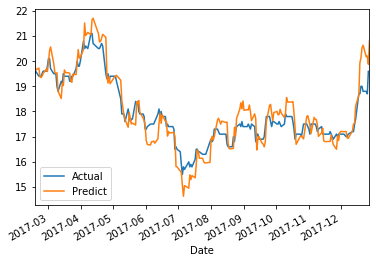

In [25]:
holdout[["Actual", "Predict"]].plot()

In [26]:
mse = mean_squared_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mse

0.27223094783940044

In [27]:
mae = mean_absolute_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mae

0.4016624447972331

In [28]:
r2 = r2_score(holdout[["Actual"]].values, holdout[["Predict"]].values)
r2

0.8233984427053046

In [29]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.27223094783940044,
 'mae': 0.4016624447972331,
 'r2': 0.8233984427053046}

# Test on holdout set 2: 2018-2020

In [30]:
holdout2 = df["2018-01-01":"2020-04-30"]
holdout2


inputs = {
    'open': holdout2["Open"],
    'high': holdout2["High"],
    'low': holdout2["Low"],
    'close': holdout2["Close"],
    'volume': holdout2["Volume"]
}

holdout2.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout2.loc[:,"WMA"] = WMA(inputs).tolist()
holdout2.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout2.loc[:,"ATR"] = ATR(inputs).tolist()
holdout2.loc[:,"RSI"] = RSI(inputs).tolist()

# Tomorrow actual
holdout2.loc[:,"Actual"] = holdout2["Close"].shift(-1)
holdout2.head()

# Start prediction
holdout2 = holdout2.dropna()

holdout2.loc[:,"Predict"] = model.predict(holdout2[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout2

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2018-02-13,21.600000,21.100000,21.299999,21.100000,85350600.0,17.842793,21.6840,21.583441,6.602101e+06,0.730898,52.147911,20.799999,21.699805
2018-02-14,21.299999,20.799999,21.200001,20.799999,53688000.0,17.589100,21.6480,21.538279,-2.179330e+07,0.714406,48.891391,21.799999,21.313032
2018-02-15,21.799999,20.900000,20.900000,21.799999,96710000.0,18.434731,21.6480,21.554839,-6.570262e+05,0.734805,58.250417,21.700001,22.023913
2018-02-16,22.000000,21.500000,21.900000,21.700001,77510900.0,18.350168,21.6480,21.562365,3.116924e+06,0.718033,57.123914,21.600000,21.991238
2018-02-19,21.900000,21.400000,21.799999,21.600000,44549800.0,18.265608,21.6240,21.561505,1.542512e+06,0.702460,55.958467,21.500000,21.915626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,5.700000,5.450000,5.500000,5.600000,37363900.0,5.600000,5.6148,5.682602,-2.097265e+07,0.344650,43.848519,5.550000,5.422998
2020-04-24,5.650000,5.550000,5.650000,5.550000,23071700.0,5.550000,5.6328,5.685376,-2.357443e+07,0.327175,43.071974,5.600000,5.380581
2020-04-27,5.700000,5.500000,5.600000,5.600000,25009900.0,5.600000,5.6268,5.690516,-2.249567e+07,0.318091,44.137386,5.500000,5.466010


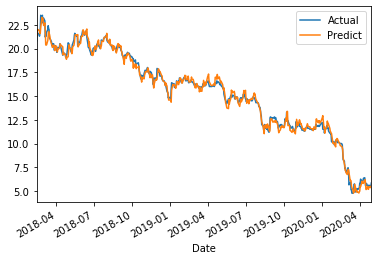

In [31]:
holdout2[["Actual", "Predict"]].plot()

In [32]:
mse = mean_squared_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mse

0.165124453831421

In [33]:
mae = mean_absolute_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mae

0.3100974797636797

In [34]:
r2 = r2_score(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
r2

0.9918119575866594

In [35]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.165124453831421, 'mae': 0.3100974797636797, 'r2': 0.9918119575866594}